# Round 2 Data


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import utils
from tqdm import tqdm
import os
import h5py
import glob
import ismrmrd
from ismrmrdtools import show, transform
import ismrmrd.xsd
global_dir = '/csiNAS/brett/RealNoiseMRI/mnt/mocodata1/MoCoChallenge/MedNeurIPS/Download_Validation_Data/'
global_dir = '/home/sidharth/'
mini_contrast   = 't2'
target_scan     =  1 # From 1 to 5

# Target files
nod_file   = global_dir + 'VAL_0%d/Scan_nod_%s.h5' % (
    target_scan, mini_contrast)

still_file = global_dir + 'VAL_0%d/Scan_still_%s.h5' % (
    target_scan, mini_contrast)


In [2]:
# print(os.listdir('/home/sidharth/VAL_01'))
# os.chdir('/home/sidharth/VAL_01')

# with h5py.File('Scan_nod_t1.h5', 'r') as F:
#     print(F.keys())
#     kspace_data = np.array(F['dataset'])
# print(kspace_data)

/home/sidharth/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
dset_nod = ismrmrd.Dataset(nod_file, 'dataset', create_if_needed=False)
header = ismrmrd.xsd.CreateFromDocument(dset_nod.read_xml_header())
enc = header.encoding[0]

# Matrix size
eNx = enc.encodedSpace.matrixSize.x
eNy = enc.encodedSpace.matrixSize.y
eNz = enc.encodedSpace.matrixSize.z
rNx = enc.reconSpace.matrixSize.x
rNy = enc.reconSpace.matrixSize.y
rNz = enc.reconSpace.matrixSize.z

# Field of View
eFOVx = enc.encodedSpace.fieldOfView_mm.x
eFOVy = enc.encodedSpace.fieldOfView_mm.y
eFOVz = enc.encodedSpace.fieldOfView_mm.z
rFOVx = enc.reconSpace.fieldOfView_mm.x
rFOVy = enc.reconSpace.fieldOfView_mm.y
rFOVz = enc.reconSpace.fieldOfView_mm.z

# Number of Slices, Reps, Contrasts, etc.
ncoils = header.acquisitionSystemInformation.receiverChannels

if enc.encodingLimits.slice != None:
    nslices = enc.encodingLimits.slice.maximum + 1
else:
    nslices = 1

if enc.encodingLimits.repetition != None:
    nreps = enc.encodingLimits.repetition.maximum + 1
else:
    nreps = 1

if enc.encodingLimits.contrast != None:
    ncontrasts = enc.encodingLimits.contrast.maximum + 1
else:
    ncontrasts = 1

# TODO loop through the acquisitions looking for noise scans
firstacq=0
for acqnum in range(dset_nod.number_of_acquisitions()):
    acq = dset_nod.read_acquisition(acqnum)
    
    # TODO: Currently ignoring noise scans
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        print("Found noise scan at acq ", acqnum)
        continue
    else:
        firstacq = acqnum
        print("Imaging acquisition starts acq ", acqnum)
        break


# Initialiaze a storage array
all_data = np.zeros((nreps, ncontrasts, nslices, ncoils, eNz, eNy, rNx),
                    dtype=np.complex64)

print(all_data.shape)
# Loop through the rest of the acquisitions and stuff
for acqnum in tqdm(range(firstacq,dset_nod.number_of_acquisitions())):
    acq = dset_nod.read_acquisition(acqnum)

    # TODO: this is where we would apply noise pre-whitening
    
    # Remove oversampling if needed
    if eNx != rNx:
        xline = transform.transform_kspace_to_image(acq.data, [1])
        x0 = int((eNx - rNx) / 2)
        x1 = int((eNx - rNx) / 2 + rNx)
        xline = xline[:,x0:x1]
        acq.resize(rNx,acq.active_channels,acq.trajectory_dimensions)
        acq.center_sample = int(rNx/2)
        # need to use the [:] notation here to fill the data
        acq.data[:] = transform.transform_image_to_kspace(xline, [1])
  
    # Stuff into the buffer
    rep = acq.idx.repetition
    contrast = acq.idx.contrast
    slice = acq.idx.slice
    y = acq.idx.kspace_encode_step_1
    z = acq.idx.kspace_encode_step_2
    all_data[rep, contrast, slice, :, z, y, :] = acq.data

# Reconstruct images
images_nod = np.zeros((nreps, ncontrasts, nslices, eNz, eNy, rNx), dtype=np.float32)
for rep in tqdm(range(nreps)):
    for contrast in range(ncontrasts):
        for slice in range(nslices):
            # FFT
            if eNz>1:
                #3D
                im = transform.transform_kspace_to_image(all_data[rep,contrast,slice,:,:,:,:], [1,2,3])
            else:
                #2D
                im = transform.transform_kspace_to_image(all_data[rep,contrast,slice,:,0,:,:], [1,2])

            # Sum of squares
            im = np.sqrt(np.sum(np.abs(im) ** 2, 0))
            
            # Stuff into the output
            if eNz>1:
                #3D
                images_nod[rep,contrast,slice,:,:,:] = im
            else:
                #2D
                images_nod[rep,contrast,slice,0,:,:] = im

# Show an image
show.imshow(np.squeeze(images_nod[0,0,6,:,:,:]), cmap='gray')

  0%|          | 11/14625 [00:00<02:17, 106.54it/s]

Found noise scan at acq  0
Imaging acquisition starts acq  1
(1, 1, 25, 52, 1, 520, 512)


 11%|█         | 1554/14625 [00:07<01:06, 195.69it/s]


KeyboardInterrupt: 

In [5]:

print(all_data.shape)

(52, 25, 520, 512)


/home/sidharth/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/sidharth/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


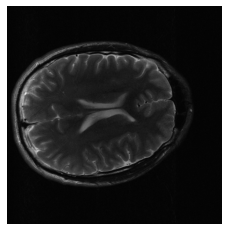

In [4]:
show.imshow(np.squeeze(images_nod[0,0,19,:,:,:]), cmap='gray')

Found noise scan at acq  0
Imaging acquisition starts acq  1


  0%|          | 17/11700 [00:00<01:08, 169.38it/s]

(1, 1, 25, 52, 1, 520, 512)


  0%|          | 0/1 [00:00<?, ?it/s]

2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition
2D Aquisition


100%|██████████| 1/1 [00:23<00:00, 23.32s/it]


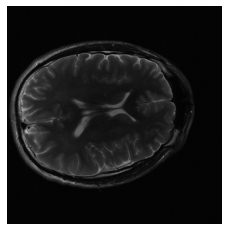

In [5]:
dset_still = ismrmrd.Dataset(still_file, 'dataset', create_if_needed=False)
header = ismrmrd.xsd.CreateFromDocument(dset_still.read_xml_header())
enc = header.encoding[0]

# Matrix size
eNx = enc.encodedSpace.matrixSize.x
eNy = enc.encodedSpace.matrixSize.y
eNz = enc.encodedSpace.matrixSize.z
rNx = enc.reconSpace.matrixSize.x
rNy = enc.reconSpace.matrixSize.y
rNz = enc.reconSpace.matrixSize.z

# Field of View
eFOVx = enc.encodedSpace.fieldOfView_mm.x
eFOVy = enc.encodedSpace.fieldOfView_mm.y
eFOVz = enc.encodedSpace.fieldOfView_mm.z
rFOVx = enc.reconSpace.fieldOfView_mm.x
rFOVy = enc.reconSpace.fieldOfView_mm.y
rFOVz = enc.reconSpace.fieldOfView_mm.z

# Number of Slices, Reps, Contrasts, etc.
ncoils = header.acquisitionSystemInformation.receiverChannels

if enc.encodingLimits.slice != None:
    nslices = enc.encodingLimits.slice.maximum + 1
else:
    nslices = 1

if enc.encodingLimits.repetition != None:
    nreps = enc.encodingLimits.repetition.maximum + 1
else:
    nreps = 1

if enc.encodingLimits.contrast != None:
    ncontrasts = enc.encodingLimits.contrast.maximum + 1
else:
    ncontrasts = 1

# TODO loop through the acquisitions looking for noise scans
firstacq=0
for acqnum in range(dset_still.number_of_acquisitions()):
    acq = dset_still.read_acquisition(acqnum)
    
    # TODO: Currently ignoring noise scans
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        print("Found noise scan at acq ", acqnum)
        continue
    else:
        firstacq = acqnum
        print("Imaging acquisition starts acq ", acqnum)
        break


# Initialiaze a storage array
all_data = np.zeros((nreps, ncontrasts, nslices, ncoils, eNz, eNy, rNx),
                    dtype=np.complex64)

print(all_data.shape)
# Loop through the rest of the acquisitions and stuff
for acqnum in tqdm(range(firstacq,dset_still.number_of_acquisitions())):
    acq = dset_still.read_acquisition(acqnum)

    # TODO: this is where we would apply noise pre-whitening
    
    # Remove oversampling if needed
    if eNx != rNx:
        xline = transform.transform_kspace_to_image(acq.data, [1])
        x0 = int((eNx - rNx) / 2)
        x1 = int((eNx - rNx) / 2 + rNx)
        xline = xline[:,x0:x1]
        acq.resize(rNx,acq.active_channels,acq.trajectory_dimensions)
        acq.center_sample = int(rNx/2)
        # need to use the [:] notation here to fill the data
        acq.data[:] = transform.transform_image_to_kspace(xline, [1])
  
    # Stuff into the buffer
    rep = acq.idx.repetition
    contrast = acq.idx.contrast
    slice = acq.idx.slice
    y = acq.idx.kspace_encode_step_1
    z = acq.idx.kspace_encode_step_2
    all_data[rep, contrast, slice, :, z, y, :] = acq.data

# Reconstruct images
images_still = np.zeros((nreps, ncontrasts, nslices, eNz, eNy, rNx), dtype=np.float32)
for rep in tqdm(range(nreps)):
    for contrast in range(ncontrasts):
        for slice in range(nslices):
            # FFT
            if eNz>1:
                #3D
                im = transform.transform_kspace_to_image(all_data[rep,contrast,slice,:,:,:,:], [1,2,3])
            else:
                print('2D Aquisition')
                #2D
                im = transform.transform_kspace_to_image(all_data[rep,contrast,slice,:,0,:,:], [1,2])

            # Sum of squares
            im = np.sqrt(np.sum(np.abs(im) ** 2, 0))
            
            # Stuff into the output
            if eNz>1:
                #3D
                images_still[rep,contrast,slice,:,:,:] = im
            else:
                #2D
                images_still[rep,contrast,slice,0,:,:] = im

# Show an image
show.imshow(np.squeeze(images_still[0,0,6,:,:,:]), cmap='gray')

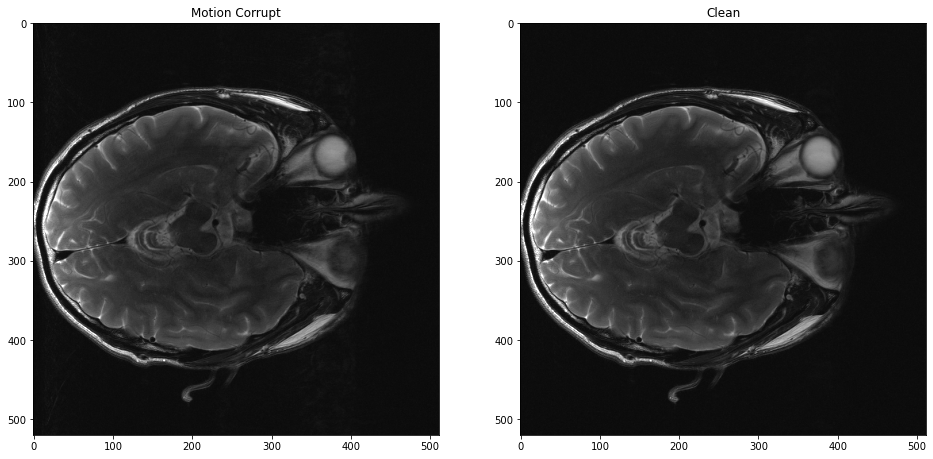

In [27]:
import matplotlib.pyplot as plt
slice = 3
plt.figure(figsize = (16,12))
plt.subplot(1,2,1)
plt.title('Motion Corrupt')
plt.imshow(abs(np.squeeze(images_nod[0,0,slice,:,:,:])), vmax = 0.001, vmin =0, cmap='gray')
plt.subplot(1,2,2)
plt.title('Clean')
plt.imshow(abs(np.squeeze(images_still[0,0,slice,:,:,:])), vmax = 0.001  , vmin =0,cmap='gray')

In [7]:
print(np.max(abs(np.squeeze(images_still[0,0,15,:,:,:]))))

0.0


In [8]:
dset_still = ismrmrd.Dataset(still_file, 'dataset', create_if_needed=False)
header = ismrmrd.xsd.CreateFromDocument(dset_still.read_xml_header())
enc = header.encoding[0]

In [9]:
print(enc)

encodingType(encodedSpace=encodingSpaceType(matrixSize=matrixSizeType(x=1024, y=520, z=1), fieldOfView_mm=fieldOfViewMm(x=460.0, y=233.679993, z=7.5)), reconSpace=encodingSpaceType(matrixSize=matrixSizeType(x=512, y=512, z=1), fieldOfView_mm=fieldOfViewMm(x=230.0, y=230.0, z=5.0)), encodingLimits=encodingLimitsType(kspace_encoding_step_0=None, kspace_encoding_step_1=limitType(minimum=0, maximum=467, center=234), kspace_encoding_step_2=limitType(minimum=0, maximum=0, center=0), average=limitType(minimum=0, maximum=1, center=0), slice=limitType(minimum=0, maximum=24, center=0), contrast=limitType(minimum=0, maximum=0, center=0), phase=limitType(minimum=0, maximum=0, center=0), repetition=limitType(minimum=0, maximum=0, center=0), set=limitType(minimum=0, maximum=0, center=0), segment=limitType(minimum=0, maximum=0, center=0)), trajectory=<trajectoryType.CARTESIAN: 'cartesian'>, trajectoryDescription=None, parallelImaging=parallelImagingType(accelerationFactor=accelerationFactorType(kspac

/home/sidharth/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
print(header)

ismrmrdHeader(version=None, subjectInformation=None, studyInformation=studyInformationType(studyDate=None, studyTime=XmlTime(10, 36, 43, 0), studyID=None, accessionNumber=None, referringPhysicianName=None, studyDescription=None, studyInstanceUID=None), measurementInformation=measurementInformationType(measurementID='166141_11153352_11153357_31', seriesDate=None, seriesTime=None, patientPosition=<patientPositionType.HFS: 'HFS'>, initialSeriesNumber=None, protocolName='TCLmoco_off_still_t2_tse_tra_512_TE115ms', seriesDescription=None, measurementDependency=[measurementDependencyType(dependencyType='SenMap', measurementID='166141_11153352_11153357_30'), measurementDependencyType(dependencyType='Noise', measurementID='166141_11153352_11153357_30')], seriesInstanceUIDRoot=None, frameOfReferenceUID='1.3.12.2.1107.5.2.43.166141.1.20210217100137711.0.0.0', referencedImageSequence=None), acquisitionSystemInformation=acquisitionSystemInformationType(systemVendor='SIEMENS', systemModel='Prisma', 